In [1]:
from pathlib import Path
parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [2]:
from utils import *
from ergm import ERGM
from metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Replicating the `Sampson` example from R's ERGM
The original R ERGM paper (Hunter et al. 2008) begins with a basic example of modeling Sampson's Monestary data, which consists of a directed network with $n=18$ nodes. This network models social interactions among a group of monks (See Sampson 1969 for more details). 

In the paper, An ERGM model is fit based on the Sampson network, using `num_of_edges` as its sole feature. The R fit yields a coefficient of `-0.9071582`, which is our aim.

In [3]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 
    [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)


Initial thetas - [0.46581701]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.18, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.50, sample_size: 551, sliding_grad_window_k: 23
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.0, hotelling_critical_value=0.003935730375712225


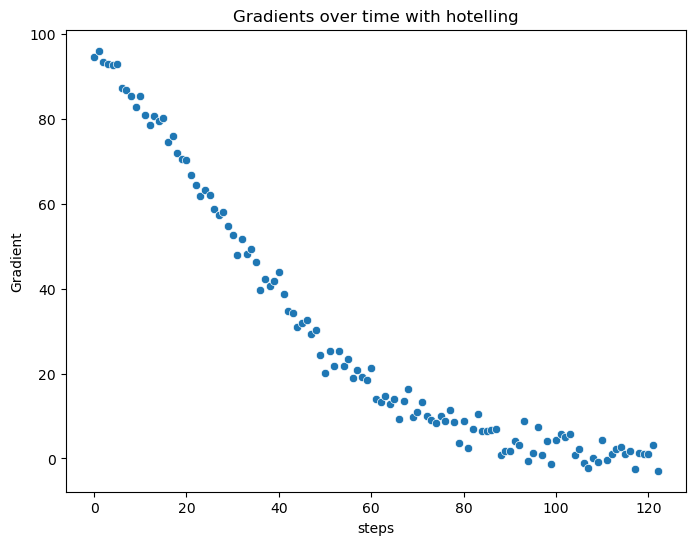

Fitted theta: [-0.88204551]


In [34]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()
fitted_model = ERGM(n, [number_of_edges_metric], is_directed=is_directed, sample_size=500, n_mcmc_steps=50)

convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=300, 
                         lr_decay_pct=0.1, steps_for_decay=50,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=0.95
                         )

grads = [x[0] for x in grads]


fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title(f"Gradients over time with {convergence_criterion}")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

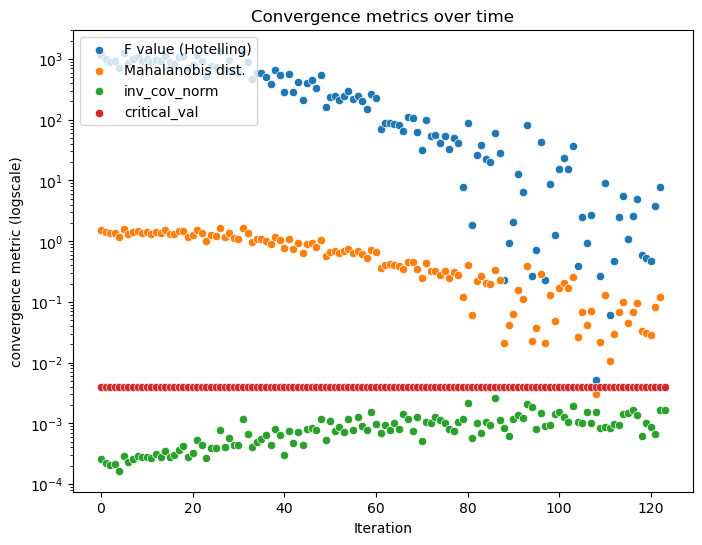

In [35]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


As we can see, our model reaches a theta that is extremely close to the actual R result.

In [7]:
min(hotelling)

3.6470473599830022

10847918.021540165

## Now test a model with TotalReciprocity + NumberOfEdges

Initial thetas - [ 0.57095926 -0.14783974]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.04, sample_size: 500, sliding_grad_window_k: 20
	 Sample size increased at step 50 to 525
Step 51 - lr: 0.0450000000, time from start: 1.35, sample_size: 525, sliding_grad_window_k: 21
	 Sample size increased at step 100 to 551
Step 101 - lr: 0.0405000000, time from start: 2.72, sample_size: 551, sliding_grad_window_k: 23
	 Sample size increased at step 150 to 578
Step 151 - lr: 0.0364500000, time from start: 4.13, sample_size: 578, sliding_grad_window_k: 25
	 Sample size increased at step 200 to 606
Step 201 - lr: 0.0328050000, time from start: 5.59, sample_size: 606, sliding_grad_window_k: 27
Reached a confidence of 0.95 with the hotelling convergence test! DONE! 
hotelling - 0.042725689608504966, hotelling_critical_value=0.05129765059783868


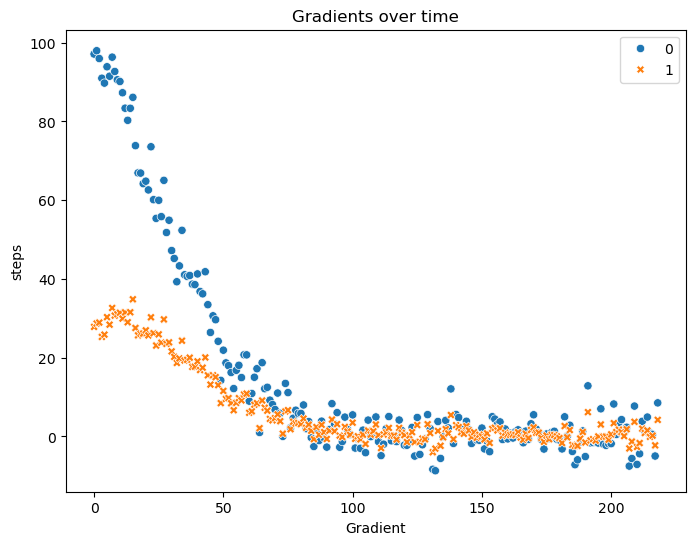

Fitted theta: [-1.7869004   2.37748828]


In [30]:
n = sampson_matrix.shape[0]
is_directed = True

number_of_edges_metric = NumberOfEdgesDirected() if is_directed else NumberOfEdgesUndirected()

estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [number_of_edges_metric, TotalReciprocity()]
fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=500, n_mcmc_steps=20, seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=500, 
                         lr_decay_pct=0.1, steps_for_decay=50,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=0.95
                         )

# grads, _ = fitted_model.fit(sampson_matrix, lr=1, opt_steps=400, sliding_grad_window_k=20, sample_pct_growth=0.05, lr_decay_pct=0.1, steps_for_decay=10)


fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(grads, ax=ax)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

#### Took a while (~1 minute), but results are pretty close!
True results in R -
* $\theta_1 = -1.7625$
* $\theta_2 = 2.3132$

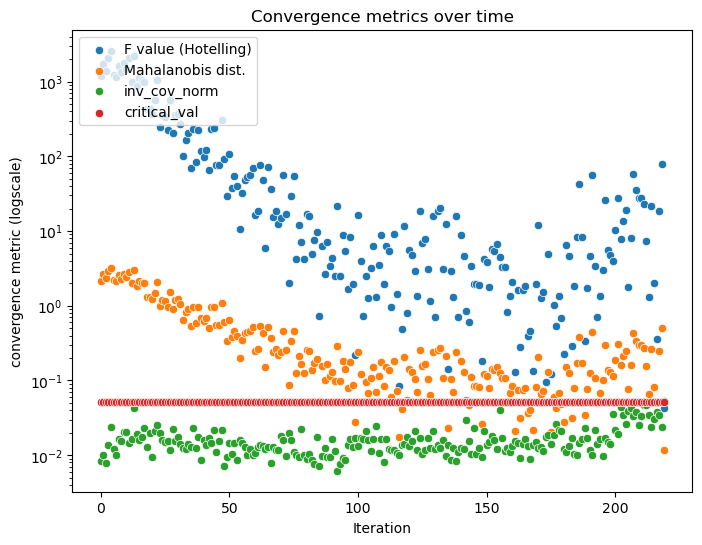

In [31]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper left")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


## And finally we test the full $p_1$ model

Initial thetas - [ 0.00690219  0.63784012 -0.80916284 -0.51795693 -0.08793763 -0.35014978
 -0.34405651 -0.83443201  0.94979597  0.00134484  0.30764103 -0.11915048
  0.31021762  0.91709605  0.930857    0.07010162 -0.22534056  0.09518903
  0.24309313  0.82198554  0.58300828 -0.10112198  0.66074503 -0.63295961
  0.29283701 -0.71571922 -0.4793006  -0.77470333  0.63527253  0.00581026
 -0.94941993  0.0448054   0.37346368 -0.93281646  0.81401494 -0.8849009 ]
optimization started
Step 1 - lr: 0.0500000000, time from start: 0.61, sample_size: 5000, sliding_grad_window_k: 20
Step 26 - lr: 0.0450000000, time from start: 15.49, sample_size: 5000, sliding_grad_window_k: 21
Step 51 - lr: 0.0405000000, time from start: 31.19, sample_size: 5000, sliding_grad_window_k: 23
Step 76 - lr: 0.0364500000, time from start: 46.52, sample_size: 5000, sliding_grad_window_k: 25
Step 101 - lr: 0.0328050000, time from start: 61.65, sample_size: 5000, sliding_grad_window_k: 27
Step 126 - lr: 0.0295245000, time from 

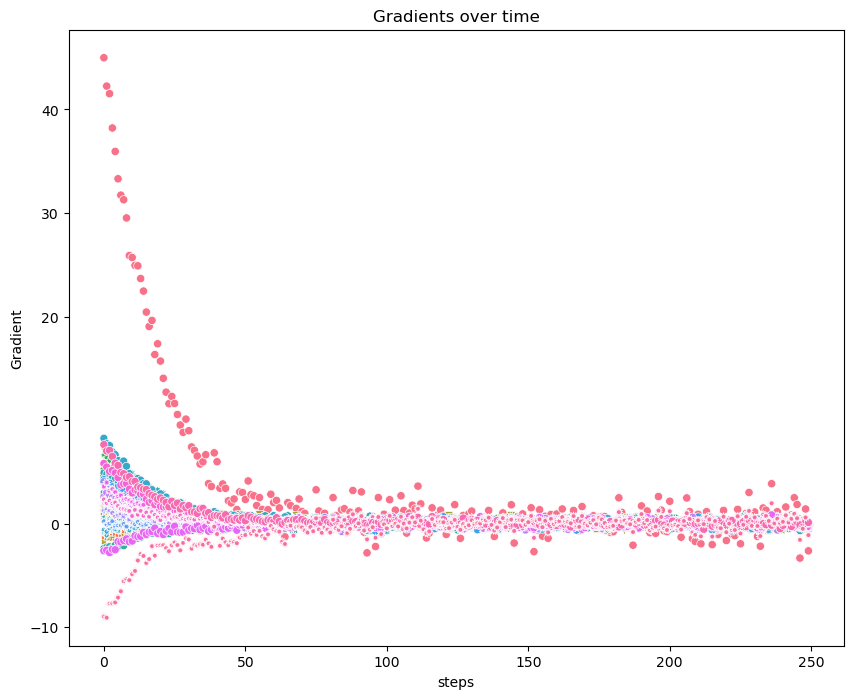

Fitted theta: [-1.2003524  -0.2165809   1.47854927  0.3922377   0.1733444   1.27975215
  0.65040622  1.41169626  0.66581589  2.13183598  1.47928353 -0.10305166
 -0.20552583  0.64926197  1.93106672  1.47982013  1.28503004  1.91059332
 -0.17643267 -3.07965939 -1.78771007 -0.86479492 -3.46661386 -1.61190754
 -2.33749966 -2.25343194 -3.95444387 -3.09437726 -0.99547917 -1.49872054
 -1.62500759 -3.32583582 -3.06382488 -3.44909422 -3.32911803  3.72601957]


In [69]:
n = sampson_matrix.shape[0]
is_directed = True



estimated_p_seed = np.sum(sampson_matrix) / (n*(n-1))

metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=5000, n_mcmc_steps=20, seed_MCMC_proba=estimated_p_seed)

# convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"

hotelling_conf = 0.99
grads, hotelling = fitted_model.fit(sampson_matrix, lr=0.05, opt_steps=250, 
                         lr_decay_pct=0.1, steps_for_decay=25,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=hotelling_conf,
                         )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

In [50]:
df["hotelling_F"].min()

2.053797499134223

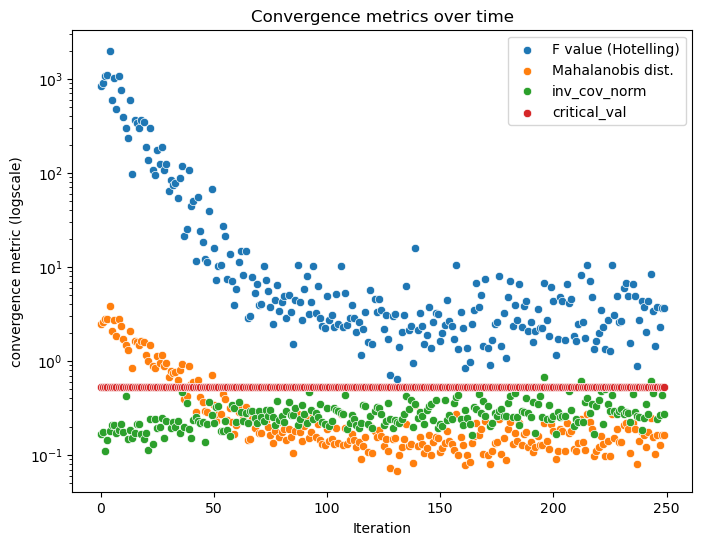

In [70]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()


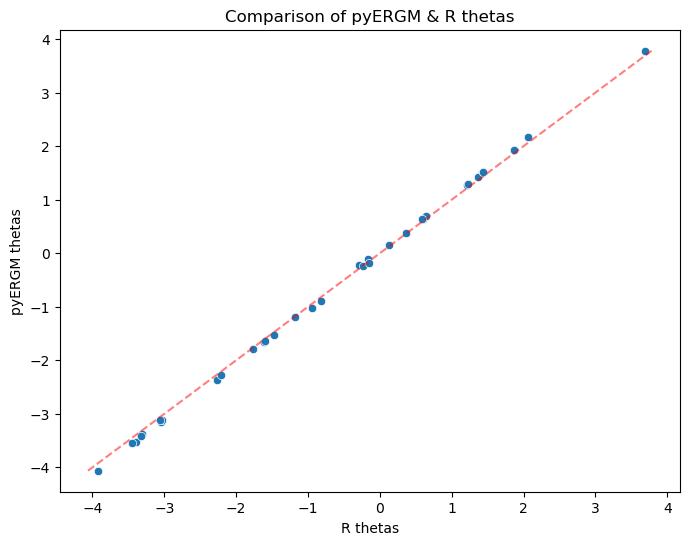

In [66]:
true_values = {"edges":      -1.1761, "sender2":    -0.2945, "sender3":     1.4141, "sender4":     0.3662, "sender5":     0.1315, "sender6":     1.2148, "sender7":     0.6055,
"sender8":     1.3609, "sender9":     0.6402, "sender10":    2.0639, "sender11":    1.4355, "sender12":   -0.1681, "sender13":   -0.2322, "sender14":    0.5841, "sender15":    1.8600,
"sender16":    1.4317, "sender17":    1.2211, "sender18":    1.8724, "receiver2":  -0.1522, "receiver3":  -3.0453, "receiver4":  -1.7596, "receiver5":  -0.8198, "receiver6":  -3.3922,
"receiver7":  -1.6074, "receiver8":  -2.2656, "receiver9":  -2.2069, "receiver10": -3.9189, "receiver11": -3.0257, "receiver12": -0.9457, "receiver13": -1.4749, "receiver14": -1.5950,
"receiver15": -3.3147, "receiver16": -3.0567, "receiver17": -3.4436, "receiver18": -3.3239, "mutual":       3.6918
}

true_predictions = np.array(list(true_values.values()))
fitted_thetas = fitted_model._thetas

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=true_predictions, y=fitted_thetas)

min_x = min(min(true_predictions), min(fitted_thetas))
max_x = max(max(true_predictions), max(fitted_thetas))

sns.lineplot(x=[min_x, max_x], y=[min_x, max_x], color="red", linestyle="--", alpha=0.5)
ax.set(xlabel='R thetas', ylabel='pyERGM thetas')
ax.set_title("Comparison of pyERGM & R thetas")
plt.show()


<Axes: ylabel='critical_val'>

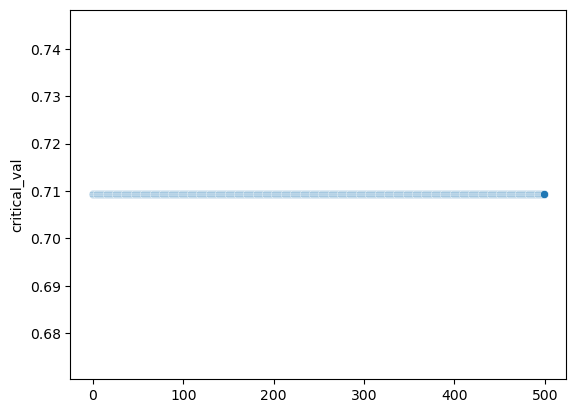

In [40]:
sns.scatterplot(df["critical_val"])

In [100]:
gals_data = pd.read_csv("./connectome_data.csv")
gals_data = gals_data.drop("Unnamed: 0", axis=1)

W = gals_data.values

W = W[:50, :50]

Initial thetas - [0.09456169 0.65342612]
optimization started
Step 1 - lr: 0.0500000000, time from start: 4.26, sample_size: 50000, sliding_grad_window_k: 20
Step 26 - lr: 0.0450000000, time from start: 103.05, sample_size: 50000, sliding_grad_window_k: 21
Step 51 - lr: 0.0405000000, time from start: 197.09, sample_size: 50000, sliding_grad_window_k: 23
Step 76 - lr: 0.0364500000, time from start: 287.77, sample_size: 50000, sliding_grad_window_k: 25
Step 101 - lr: 0.0328050000, time from start: 377.09, sample_size: 50000, sliding_grad_window_k: 27
Step 126 - lr: 0.0295245000, time from start: 466.32, sample_size: 50000, sliding_grad_window_k: 29
Step 151 - lr: 0.0265720500, time from start: 555.39, sample_size: 50000, sliding_grad_window_k: 31
Step 176 - lr: 0.0239148450, time from start: 644.42, sample_size: 50000, sliding_grad_window_k: 33
Step 201 - lr: 0.0215233605, time from start: 732.88, sample_size: 50000, sliding_grad_window_k: 35
Step 226 - lr: 0.0193710245, time from start:

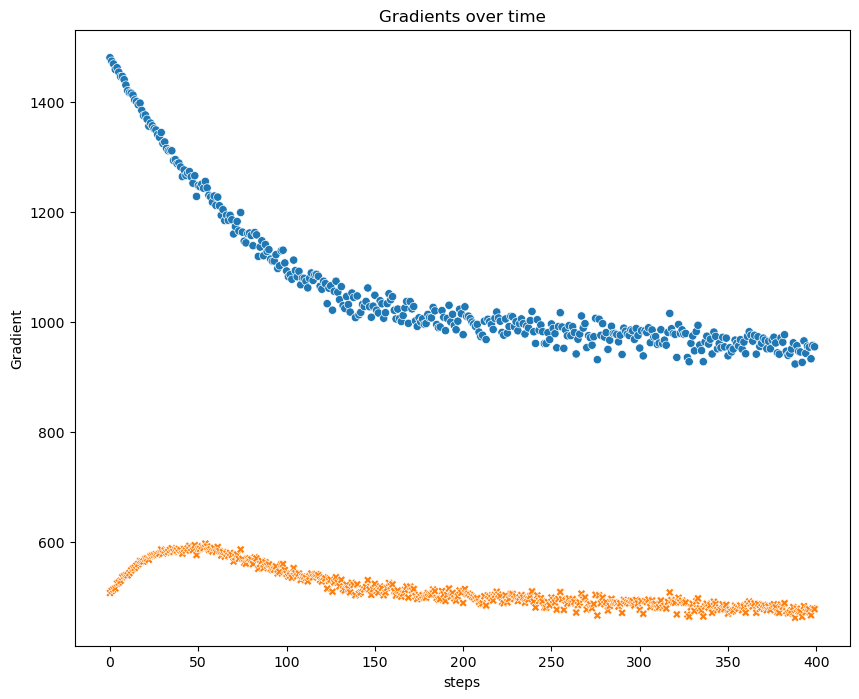

Fitted theta: [-4.13136881  8.13718439]


In [101]:
n = W.shape[0]
is_directed = True

estimated_p_seed = np.sum(W) / (n*(n-1))

metrics = [NumberOfEdgesDirected(), TotalReciprocity()]

fitted_model = ERGM(n, metrics, is_directed=is_directed, sample_size=50000, n_mcmc_steps=n, seed_MCMC_proba=estimated_p_seed)

# # convergence_criterion = "zero_grad_norm"
convergence_criterion = "hotelling"

hotelling_conf = 0.9
grads, hotelling = fitted_model.fit(W, lr=0.05, opt_steps=400, 
                         lr_decay_pct=0.1, steps_for_decay=25,
                         sliding_grad_window_k=20, sample_pct_growth=0.05, 
                         convergence_criterion=convergence_criterion, 
                         optimization_method="newton_raphson",
                         hotelling_confidence=hotelling_conf,
                         )

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(grads, ax=ax, legend=False)
ax.set(xlabel='steps', ylabel='Gradient')
ax.set_title("Gradients over time")
plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

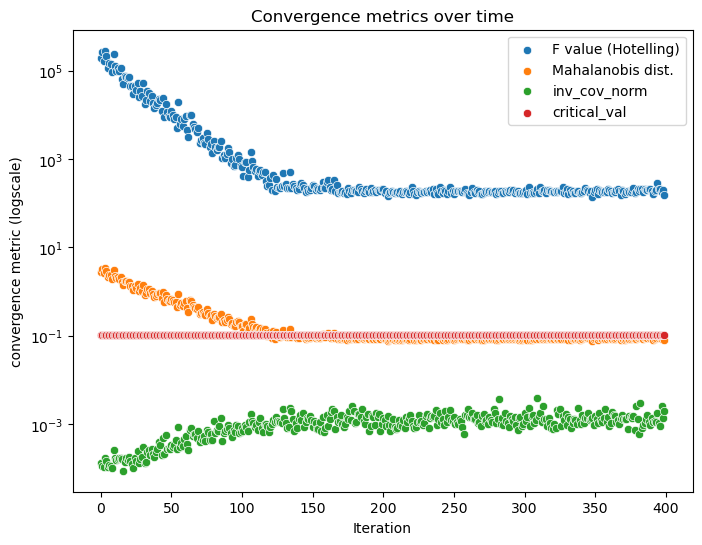

In [102]:
df = pd.DataFrame(hotelling)

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(df["hotelling_F"])
# sns.scatterplot(df["hotelling_t"])
sns.scatterplot(df["dist"])
sns.scatterplot(df["inv_cov_norm"])
sns.scatterplot(df["critical_val"])

# sns.scatterplot(df["hessian_norm"])
ax.set_yscale("log")

ax.legend(["F value (Hotelling)", "Mahalanobis dist.",  "inv_cov_norm", "critical_val",], loc="upper right")
ax.set(xlabel='Iteration', ylabel='convergence metric (logscale)')
ax.set_title("Convergence metrics over time")


plt.show()
